In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset (if not already in memory)
file_path = "data/featured_clinvar_result.csv"
df = pd.read_csv(file_path)

In [3]:
# Select features and target
X = df.drop(columns=["position", "label"])
y = df["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversample the training set
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Ensure int32 dtype
X_train = X_train.astype("int32")
X_test = X_test.astype("int32")

In [4]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [6]:
# DataLoaders
dtrain = TensorDataset(X_train_tensor, y_train_tensor)
dtest = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dtrain, batch_size=64, shuffle=True)
test_loader = DataLoader(dtest, batch_size=64, shuffle=False)

In [7]:
# Define Neural Network
def define_model(trial):
    layers = []
    in_features = X_train.shape[1]
    n_layers = trial.suggest_int("n_layers", 1, 3)

    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 16, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(trial.suggest_float(f"dropout_l{i}", 0.1, 0.5)))
        in_features = out_features

    layers.append(nn.Linear(in_features, 2))  # Binary classification
    return nn.Sequential(*layers)

In [8]:
# Training function
def train(model, optimizer, criterion):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / len(train_loader), correct / total

# Validation function
def validate(model, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            _, pred = torch.max(out, 1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return val_loss / len(test_loader), correct / total

In [9]:
# Evaluation function
def evaluate(model):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            _, predicted = torch.max(out, 1)
            preds.extend(predicted.numpy())
            true.extend(yb.numpy())
    return preds, true

In [10]:
# Objective function for Optuna
def objective(trial):
    model = define_model(trial)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    n_epochs = 50
    for epoch in range(n_epochs):
        train_loss, train_acc = train(model, optimizer, criterion)
    preds, true = evaluate(model)
    return accuracy_score(true, preds)

In [11]:
# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-06-26 18:16:53,632] A new study created in memory with name: no-name-edd60848-1cba-4622-9470-4cf31131ce1b
[I 2025-06-26 18:16:59,768] Trial 0 finished with value: 0.9465020576131687 and parameters: {'n_layers': 3, 'n_units_l0': 35, 'dropout_l0': 0.24239859212690745, 'n_units_l1': 25, 'dropout_l1': 0.4871849147050329, 'n_units_l2': 109, 'dropout_l2': 0.22394789837985019, 'lr': 0.0014146301392586572}. Best is trial 0 with value: 0.9465020576131687.
[I 2025-06-26 18:17:06,586] Trial 1 finished with value: 0.9465020576131687 and parameters: {'n_layers': 3, 'n_units_l0': 92, 'dropout_l0': 0.10439026782875858, 'n_units_l1': 125, 'dropout_l1': 0.2642246838105816, 'n_units_l2': 61, 'dropout_l2': 0.10304205227882238, 'lr': 0.019028442589885324}. Best is trial 0 with value: 0.9465020576131687.
[I 2025-06-26 18:17:09,616] Trial 2 finished with value: 0.9547325102880658 and parameters: {'n_layers': 2, 'n_units_l0': 118, 'dropout_l0': 0.16848306646402525, 'n_units_l1': 77, 'dropout_l1': 0.2

In [12]:
# Train best model
best_trial = study.best_trial
best_model = define_model(best_trial)
optimizer = optim.Adam(best_model.parameters(), lr=best_trial.params['lr'])
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    train_loss, train_acc = train(best_model, optimizer, criterion)
    val_loss, val_acc = validate(best_model, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

In [13]:
# Final Evaluation
preds, true = evaluate(best_model)
results = {
    "Accuracy": accuracy_score(true, preds),
    "Precision": precision_score(true, preds),
    "Recall": recall_score(true, preds),
    "F1 Score": f1_score(true, preds)
}

results_df = pd.DataFrame([results])
print(results_df)

   Accuracy  Precision    Recall  F1 Score
0  0.950617   0.926829  0.974359      0.95


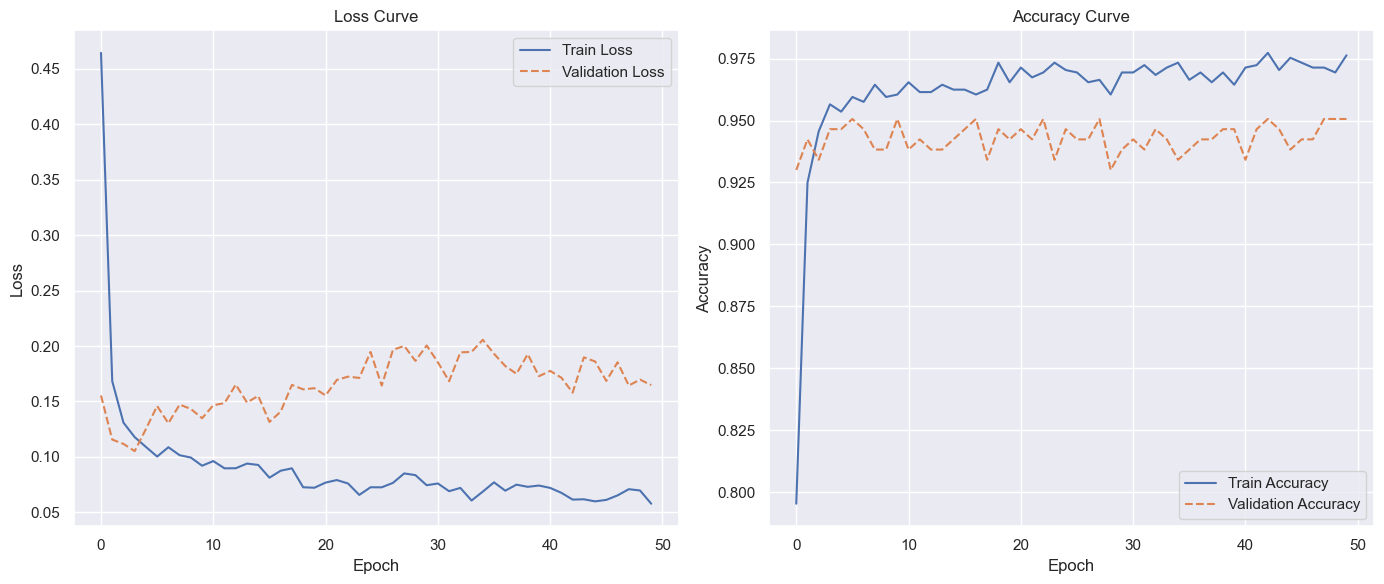

In [14]:
# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()